El objetivo de esta práctica guiada, basada en el trabajo de [Shane Lynn](https://www.shanelynn.ie/self-organising-maps-for-customer-segmentation-using-r/), es comprobar la implementación de una red SOM (Self Organizing Map) para visualizar regiones homogéneas en un conjunto de datos.

En particular, vamos a emplear información de censo de Irlanda. En concreto, esta estructura de datos incluye los siguientes campos para cada distrito alrededor de Dublín (Fingal, Dublin City, South Dublin y Dún Laoghaire-Rathdown):

* Identificador geográfico
* Edad media de los habitantes (suma ponderada y normalizada)
* Ocupación media de las viviendas (1, 2, 3 ... habitantes)
* Nivel de educación medio de los habitante
* Número de vehículos medio de los habitantes
* Estado de salud medio de los habitantes
* Porcentaje de personas que viven de alquiler
* Porcentaje de desempleo
* Porcentaje de personas con acceso a internet
* Porcentaje de solteros
* Porcentaje de casados
* Porcentaje de separados
* Porcentaje de divorciados
* Porcentaje de viudos

Nótese que todos los datos que empleamos para el SOM deben ser NUMÉRICOS. Incluso variables claramente cualitativas como el nivel de educación están tabuladas y convertidas en números en el dataset.

En los datos en origen, estos valores están desglosados por intervalos y hay que preprocesarlos para pasarlos a un formato con una columna por variable, tipo dataframe, por lo que en lugar del original, emplearemos una versión preprocesada del mismo, que cargaremos desde GitHub.

Nuestro objetivo es representar la variación de los datos en un plano, donde la información se reduce a las coordenadas x,y de dicho plano y, todo lo más, el color en que representamos dicho punto.

Habitualmente, lo queremos hacer con un propósito específico. Supongamos, por ejemplo, que deseamos saber en qué zonas es más probable que la población adquiera un vehículo, para poder repartir publicidad en dicha zona. Otros criterios basados en otras variables podrían ser, por ejemplo, decidir donde dar un meeting político de determinada ideología o dónde resultaría más útil reforzar la vigilancia policial.

Vamos a empezar por cargar librerías. Nótese que si aún no están instaladas en colab, hay que usar pip para instalarlas.

In [48]:
!pip install minisom
!pip install geopandas pandas matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
import geopandas as gpd

A continuación, descargaremos el proyecto del Github de Lynn. Aunque ahí está programado en R, esto nos da acceso en Colab a los dataset que emplea.

In [49]:
#descargar información  de mapas
!git clone https://github.com/shanealynn/Kohonen-Self-organising-maps-in-R.git

fatal: destination path 'Kohonen-Self-organising-maps-in-R' already exists and is not an empty directory.


Ahora procedemos a cargar la información de censo, que, como se ha comentado, había que preprocesar. He dejado dicha copia preprocesada en CSV en Github para agilizar este paso. Nótese que **incluye una columna id** que se corresponde con el parámetro **GEODESC** en ficheros geográficos y, en concreto, con la columna SMALL_REGIONS en el mapa de Lynn. Esto es, nos permitirá relacionar los datos de censo con la región que ocupan en el mapa.

In [5]:
# Obtener las estructuras de datos del Github que hemos clonado DataFrame de datos

# Datos del censo (CSV), ya procesados del original de Lynn
#NOTA IMPORTANTE: la columna id es el parámetro GEODESC
# URL del archivo CSV
url = 'https://raw.githubusercontent.com/crisurdiales/DataMining4SmartCities/main/Ireland_data_in_percentages.csv'

# Cargar el archivo CSV en un DataFrame de pandas
data = pd.read_csv(url)

# Ver las primeras filas del DataFrame para asegurarnos de que se ha cargado correctamente
print(data.head())

   Unnamed: 0         id    avr_age  avr_household_size  avr_education_level  \
0       15687  267123023  40.028112            2.524752             3.038462   
1       13895  267016001  35.673660            3.320611             3.597701   
2       13896  267016002  35.882353            3.324324             4.295302   
3       13729  267002034  38.516667            3.088608             3.871795   
4       13724  267002029  24.678005            3.512000             3.933735   

   avr_num_cars  avr_health  rented_percent  unemployment_percent  \
0      1.039604    4.385542        6.930693             15.343915   
1      1.983740    4.509434        4.878049             12.461059   
2      1.905405    4.596639        1.351351             10.404624   
3      1.730769    4.530172        3.896104              8.108108   
4      1.112000    4.510345       20.800000             21.810700   

   internet_percent  single_percent  married_percent  separated_percent  \
0         71.000000       53.

A continuación, hay que preparar los datos para alimentar la red SOM, que han de ser todos numéricos y estar completos. Esto es, si falta algún valor, lo reemplazamos por la media de la columna correspondiente.

In [50]:
# Identificar filas con valores faltantes en avr_education_level
incompletes = data[data['avr_education_level'].isna()].index

# Calcular la media de avr_education_level excluyendo los valores faltantes
mean_education_level = data['avr_education_level'].mean(skipna=True)

# Reemplazar los valores faltantes en avr_education_level con la media
data.loc[incompletes, 'avr_education_level'] = mean_education_level

# Volver a identificar filas con valores faltantes después del reemplazo
incompletes = data[data['avr_education_level'].isna()].index

# Eliminar filas con valores faltantes en cualquier columna
data = data.dropna()

# Imprimir el número de filas eliminadas
if len(incompletes) > 0:
    print(f"Removing {len(incompletes)} data points that have missing values.")

# Eliminar la variable 'incompletes'
del incompletes

# Verificar el DataFrame resultante
print(data.head())

   Unnamed: 0         id    avr_age  avr_household_size  avr_education_level  \
0       15687  267123023  40.028112            2.524752             3.038462   
1       13895  267016001  35.673660            3.320611             3.597701   
2       13896  267016002  35.882353            3.324324             4.295302   
3       13729  267002034  38.516667            3.088608             3.871795   
4       13724  267002029  24.678005            3.512000             3.933735   

   avr_num_cars  avr_health  rented_percent  unemployment_percent  \
0      1.039604    4.385542        6.930693             15.343915   
1      1.983740    4.509434        4.878049             12.461059   
2      1.905405    4.596639        1.351351             10.404624   
3      1.730769    4.530172        3.896104              8.108108   
4      1.112000    4.510345       20.800000             21.810700   

   internet_percent  single_percent  married_percent  separated_percent  \
0         71.000000       53.

Finalmente, preparemos los datos completos para entrenar el SOM, esto es:

*   Escoger las variables más relevantes para  agrupar en el plano del problema que deseamos, que en este caso es determinar donde potencialmente se comprarían más coches. Por ejemplo, edad media, educacion, número medio de coches por unidad familiar y porcentaje de desempleo de la población de cada región. Podríamos ajustar estas columnas según el criterio o estudios previos.
*   Normalizarlos, para que las variables estén en rangos similares



In [51]:
# Seleccionar las columnas relevantes del DataFrame original (data_raw) para entrenamiento
data_train = data[['avr_age', 'avr_education_level', 'avr_num_cars', 'unemployment_percent']]
# Convertir los datos seleccionados a una matriz numpy
data_train = data_train.values

# Normalizar los datos
mean_values = np.mean(data_train, axis=0)  # Calcular la media por columna
std_values = np.std(data_train, axis=0)    # Calcular la desviación estándar por columna

# Aplicar la normalización (z-score)
data_train_normalized = (data_train - mean_values) / std_values

# Verificar las estadísticas de los datos normalizados
print("Media de los datos normalizados:")
print(np.mean(data_train_normalized, axis=0))
print("Desviación estándar de los datos normalizados:")
print(np.std(data_train_normalized, axis=0))


Media de los datos normalizados:
[-1.11691839e-15  3.72306129e-16  3.37182910e-16  1.68591455e-16]
Desviación estándar de los datos normalizados:
[1. 1. 1. 1.]


Ahora pasamos a inicializar y entrenar el SOM.

La incialización consiste en crear una red neuronal tipo SOM con una estructura de NxN células, donde cada unidad tiene tantos pesos (vector de códigos) como variables con que trabajamos en los datos (data_train_normalized), en nuestro caso, las 4 variables independientes que hemos señalado antes. Los pesos se inicializan aleatoriamente, y a continuación se asigna cada vector de datos a la neurona más parecida en pesos a si mismo.

Escoger el número de celdas *sin conocimiento a priori* suele ser un tema de ensayo/error, más allá de que el número de neuronas debe ser significativamente menor que el número de vectores de datos. Un mapa más grande puede capturar más detalles y variabilidad en los datos, mientras que un mapa más pequeño puede generalizar más. En este caso vamos a usar 20x20 neuronas, configuraremos el SOM y entrenaremos con los datos normalizados.


Tras esta inicialización se procede al entrenamiento, fijando el número de iteraciones que deseemos (en nuestro caso, 100). Durante dicho entrenamiento, los pesos de las neuronas se ajustarán gradualmente para representar mejor la estructura de los datos y la distribución de características. De forma muy sucinta, cada vector de datos busca una neurona ganadora, aquella en que la distancia euclidea entre sus pesos y el propio dato es mínima en esa iteración. Dicha neurona ajusta sus pesos para incrementar el parecido con el vector y sus vecinas, hasta el tamaño de vecindad que deseemos, lo hacen también, aunque en menor medida que la neurona ganadora. Una vez concluido el proceso, se repite iterativamente hasta que converja, esto es, las neuronas ganadoras sean las mismas que en la iteración anterior para todos los datos de entrada, o hasta que pasen las iteraciones seleccionadas.

Una vez finalizado el proceso, se asume que se ha alcanzado una configuración estable donde los vecinos en el espacio SOM representan regiones similares del espacio de características original



In [52]:
# Configuración del SOM
som_shape = (20, 20)  # Tamaño del mapa SOM (20x20)
som = MiniSom(som_shape[0], som_shape[1], data_train_normalized.shape[1], sigma=1.0, learning_rate=0.5)

# Inicializar pesos aleatorios
som.random_weights_init(data_train_normalized)

# Entrenar el SOM
som.train_random(data_train_normalized, 200)  # 100 iteraciones de entrenamiento


Para comprobar visualmente el resultado del proceso, podemos colorear una rejilla del mismo tamaño que la red en función de alguno de los parámetros del mismo, por ejemplo la distancia de vecindad entre nodos.

Puede entenderse que los nodos más distantes del resto(rojos) representan regiones más distintas en términos de las variables seleccionadas, mientras que los más parecidos tienen valores más similares, ésto es, podrían fundirse en un número inferior de regiones posteriormente.

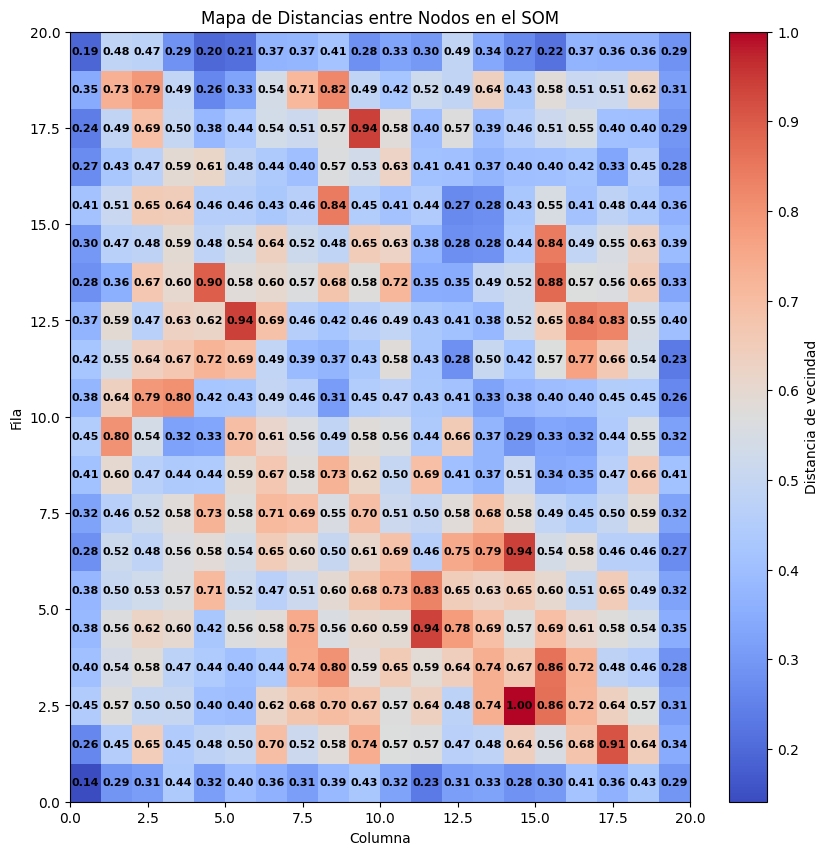

Valor de som.distance_map en la neurona (2,4) [ubicación (0,0) en Python]: 0.6547320249066307


In [54]:
# Visualización del SOM con etiquetas de distancia_map
plt.figure(figsize=(10, 10))

# Obtener el mapa de distancia entre nodos del SOM
distance_map = som.distance_map().T  # Transponer para que las coordenadas (i, j) coincidan con la visualización

# Crear el gráfico de mapa de calor con distancias entre nodos
heatmap = plt.pcolor(distance_map, cmap='coolwarm')  # Mapa de calor de distancias entre nodos
plt.colorbar(heatmap, label='Distancia de vecindad')  # Agregar barra de color con etiqueta

# Agregar etiquetas de texto con valores de distance_map en cada celda
for i in range(distance_map.shape[0]):
    for j in range(distance_map.shape[1]):
        value = distance_map[i, j]
        plt.text(j + 0.5, i + 0.5, f'{value:.2f}',  # Colocar etiqueta en el centro de cada celda
                 ha='center', va='center', color='black', fontsize=8, fontweight='bold')

# Configuración adicional de la visualización
plt.title('Mapa de Distancias entre Nodos en el SOM')
plt.xlabel('Columna')
plt.ylabel('Fila')

# Mostrar la visualización
plt.show()

distance_value_2_4 = som.distance_map()[2, 15]  # Python usa índices base 0, por lo que (1,1) es (0,0) en Python
print(f"Valor de som.distance_map en la neurona (2,4) [ubicación (0,0) en Python]: {distance_value_2_4}")

Podemos comprobar también cuantos elementos se relacionan con cada neurona, ya que si hay muchas neuronas vacías, podría ser interesante reducir el tamaño del SOM o, definitivamente, fundir grupos.

Para ello, por ejemplo, sumamos cuántos datos orinales se parecen más a cada neurona del SOM, esto es, comprobamos cual es la neurona ganadora para cada dato de entrenamiento (winner_coordinates), y en un array del tamaño de la red sumamos 1 a la celda i,j por cada dato al que se le asigna como ganadora.


In [55]:
print(data_train_normalized[0,])
print(som.winner(data_train_normalized[0,]))
print(element_count[0,0])
print(element_count[0,1])
print(element_count[0,2])

[ 0.7123814  -1.07141555 -0.14403438  0.37988459]
(13, 8)
30.0
5.0
23.0


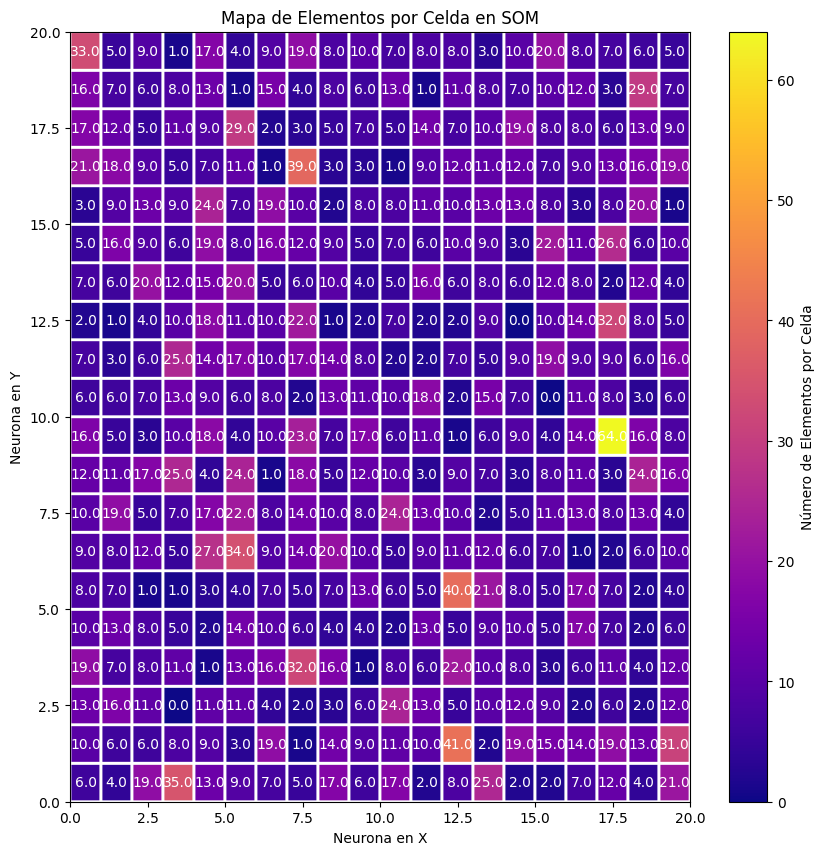

In [57]:
# Obtener la asignación de las muestras a las neuronas ganadoras
winner_coordinates = np.array([som.winner(x) for x in data_train_normalized])

# Contar el número de elementos por celda (neurona) en el SOM
element_count = np.zeros(som_shape)

for coord in winner_coordinates:
    element_count[coord[0], coord[1]] += 1

# Crear un mapa de color personalizado basado en el recuento de elementos por celda
plt.figure(figsize=(10, 10))
heatmap = plt.pcolor(element_count, cmap='plasma', edgecolors='w', linewidths=2)
plt.colorbar(heatmap, label='Número de Elementos por Celda')

# Agregar el valor de element_count como texto en el centro de cada celda
for i in range(element_count.shape[0]):
    for j in range(element_count.shape[1]):
        value = element_count[i, j]
        plt.text(j + 0.5, i + 0.5, f'{value}',  # Colocar el valor de element_count como texto en el centro de cada celda
                 ha='center', va='center', color='white', fontsize=10)

plt.title('Mapa de Elementos por Celda en SOM')
plt.xlabel('Neurona en X')
plt.ylabel('Neurona en Y')
plt.show()

Vistos los resultados anteriores, podemos cambiar el número de celdas o, simplemente, clusterizar los resultados para fundir regiones homogéneas. Nótese que no dividimos en clases el dataframe original, sino los vectores de código de las distintas neuronas, esto es, neuronas con pesos parecidos se agrupan en la misma clase.

Vamos a usar un clustering K-medias, por lo que, primero, para decidir cual es el número idóneo de clases, probaremos con varios (entre 1 y 16) y evaluaremos cómo varía WSS -esto es, la distancia dentro del cluster, que viene a representar la homogeneidad del mismo- al subir el número de clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

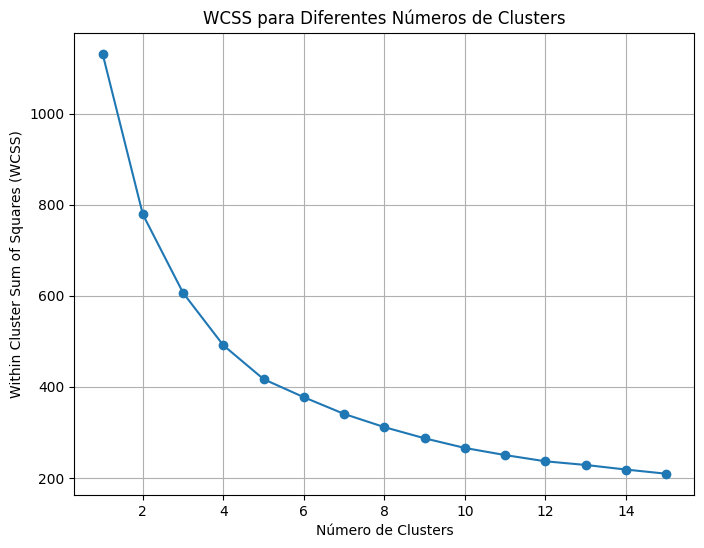

In [58]:
from sklearn.cluster import KMeans

# Obtener los vectores de código del SOM
codebook = som.get_weights()

# Visualización del WCSS (Within Cluster Sum of Squares) para diferentes números de clusters
wss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(codebook.reshape(-1, codebook.shape[2]))
    wss.append(kmeans.inertia_)

# Gráfico de WCSS vs. Número de Clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 16), wss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.title('WCSS para Diferentes Números de Clusters')
plt.grid(True)
plt.show()


Inicialmente, al haber pocos clusters permitidos, estamos forzando neuronas muy distintas en la misma clase, por lo que VCSS es muy alto. Este valor progresivamente se reduce cuando permitimos que las neuronas se distribuyan en más clases. De acuerdo al gráfico, hay un codo en 6 clusters, esto es, los resultados ya no mejoran sustancialmente al incrementar el número de clusters. Por tanto, ese es el valor que vamos a escoger para la clusterización.


In [59]:
# Aplicar KMeans para clusterizar los vectores de código
n_clusters = 6  # Número de clusters deseado (codo WCSS)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(codebook.reshape(-1, codebook.shape[2]))

# Asignar clusters al SOM utilizando KMeans
#clusters es una secuencia del cluster de cada nodo. Lo pasamos a 2D
som_cluster = clusters.reshape(som_shape[0], som_shape[1])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Para ver gráficamente los resultados, seguimos el mismo orden de los plots anteriores, indicando esta vez a qué cluster pertenece cada neurona según el parecido de sus vectores de código.

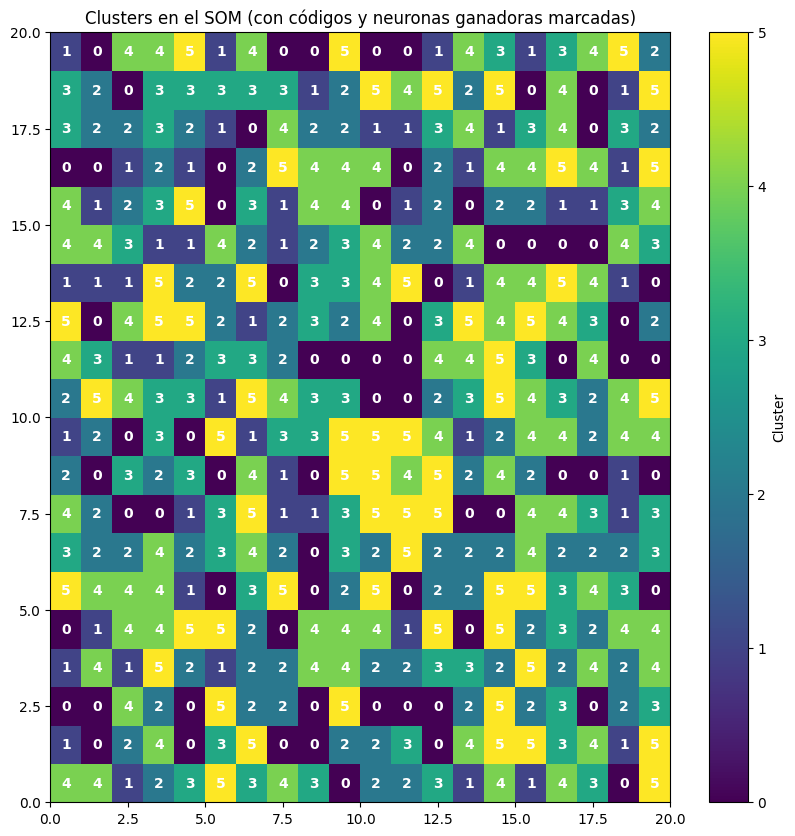

In [109]:
# Mostrar el SOM con códigos y colores para cada cluster
plt.figure(figsize=(10, 10))
plt.pcolor(som_cluster, cmap='viridis')  # Mapa de calor de clusters, sin transponer
plt.colorbar(label='Cluster')

# Dibujar límites de los clusters en el SOM
for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        cluster_code = som_cluster[i, j]
        plt.text(j + 0.5, i + 0.5, str(cluster_code),  # Cambiar el orden de j e i para que coincida con el orden del SOM
                 ha='center', va='center', color='white', fontsize=10, fontweight='bold')
"""
# DEPURACION: Marcar las neuronas ganadoras con un círculo rojo oscuro
for index, row in neuronas_ganadoras.iterrows():
    neuron_coord = row['Neurona']
    neuron_coord = neuron_coord.strip('()')  # Eliminar paréntesis
    neuron_col, neuron_row = neuron_coord.split(',')  # Dividir las coordenadas en x e y
    neuron_col = int(neuron_col)
    neuron_row = int(neuron_row)
    plt.plot(neuron_col + 0.5, neuron_row + 0.5, 'ro', markersize=10, markerfacecolor='darkred')  # Marcar con círculo rojo oscuro las neuronas ganadoras
"""
plt.title('Clusters en el SOM (con códigos y neuronas ganadoras marcadas)')
plt.show()

Una vez concluida la clusterización, tenemos en el array som_cluster de 20x20 a qué cluster pertenece cada una de las neuronas de la red. Vamos a pasar esa información a la estructura de datos original, ésto es, calcularemos a qué neurona del SOM se parece más cada dato de entrenamiento y asumiremos que su cluster es el mismo que el de su neurona ganadora. Esa información de Cluster se incorporará a data, ya que los datos de entrenamiento no son más que una versión recortada y normalizada de los de data.

In [91]:
# Crear DataFrame temporal 'temp'
temp = pd.DataFrame(data_train_normalized, columns=[f'Feature_{i}' for i in range(data_train_normalized.shape[1])])

# Calcular la neurona ganadora para cada dato de entrenamiento
winner_coordinates = np.array([som.winner(x) for x in data_train_normalized])
temp['Winner'] = [f'({coord[0]},{coord[1]})' for coord in winner_coordinates]

# Crear DataFrame 'neuronas_ganadoras'
neuronas_ganadoras = temp['Winner'].value_counts().reset_index()
neuronas_ganadoras.columns = ['Neurona', 'NWin']

# Agregar información del cluster para cada neurona ganadora
neuronas_ganadoras['Cluster'] = [som_cluster[int(coord[0]), int(coord[1])] for coord in neuronas_ganadoras['Neurona'].str.strip('()').str.split(',')]

# Combinar temp y neuronas_ganadoras en función de la columna 'Winner'
temp = temp.merge(neuronas_ganadoras, left_on='Winner', right_on='Neurona', how='left')

# Agregar la columna 'Cluster' de neuronas_ganadoras a temp
temp.drop(columns=['Neurona'], inplace=True)  # Eliminar la columna 'Neurona' que ya no necesitamos

data['Cluster'] = temp['Cluster']

print(data.head())

   Feature_0  Feature_1  Feature_2  Feature_3   Winner  NWin  Cluster
0   0.712381  -1.071416  -0.144034   0.379885   (13,8)    10        3
1   0.070847  -0.674283   1.999711   0.001420    (4,3)     5        4
2   0.101593  -0.178896   1.821846  -0.268552    (3,8)    16        4
3   0.489703  -0.479641   1.425319  -0.570041  (13,15)    12        4
4  -1.549125  -0.435656   0.020347   1.228852    (5,9)    13        2


Dado que ahora tenemos en el mismo dataframe (data) la información original de censo y el cluster que ha aportado la combinación de k-Means y el SOM, podemos intentar interpretar la  naturaleza de las regiones que se han definido.

Por ejemplo, podemos calcular la media y la mediana absoluta de la desviación mediana (MAD) en cuanto a las magnitudes por las que hemos agrupado. La MAD es una medida robusta de dispersión que se calcula utilizando la mediana y desviaciones absolutas, lo que la hace menos sensible a los valores atípicos en comparación con la varianza, que se basa en la media y desviaciones al cuadrado. Esto la convierte en una opción útil cuando se desea una medida de dispersión resistente a los outliers en conjuntos de datos con valores extremos.


In [105]:
# Definir una función para calcular MAD
def median_absolute_deviation(x):
    median_x = np.median(x)
    mad = np.median(np.abs(x - median_x))
    return mad

# Seleccionar solo las columnas de interés
cols_of_interest = ['avr_age', 'avr_education_level', 'avr_num_cars', 'unemployment_percent', 'Cluster']
data_subset = data[cols_of_interest]

# Calcular la media por cluster
mean_by_cluster = data_subset.groupby('Cluster').mean()
print("Media por cluster:")
print(mean_by_cluster)

# Calcular la mediana absoluta de la desviación mediana (MAD) por cluster
mad_by_cluster = data_subset.groupby('Cluster').agg(lambda x: median_absolute_deviation(x) if np.issubdtype(x.dtype, np.number) else None)

# Eliminar la columna 'Cluster' del índice
mad_by_cluster.reset_index(inplace=True)

# Eliminar la columna 'Cluster' del DataFrame resultante
mad_by_cluster.drop('Cluster', axis=1, inplace=True)

print("\nMAD por cluster:")
print(mad_by_cluster)

Media por cluster:
           avr_age  avr_education_level  avr_num_cars  unemployment_percent
Cluster                                                                    
0        38.622449             5.843569      1.433921              5.391161
1        32.370866             6.038943      0.633042             10.524296
2        34.016973             2.917306      0.734021             23.566978
3        43.819088             3.724300      1.061413              9.361995
4        35.318175             3.995047      1.529415             10.861699
5        26.279848             5.126560      1.413035             12.169625

MAD por cluster:
    avr_age  avr_education_level  avr_num_cars  unemployment_percent
0  3.017247             0.586738      0.233620              1.545870
1  2.873183             0.621375      0.203830              3.075806
2  3.599256             0.422777      0.170492              4.198125
3  2.710000             0.529958      0.184247              2.815184
4  2.54348

Se puede observar, por ejemplo, que la población más joven en media está en el cluster 5, tiene un nivel de educación alto y un número de vehículos igualmente alto, aunque tienen un porcentaje de desempleo del 12.16%. En este sentido, la población del cluster 1, con un desempleo del 5.39%, un número de coches medio similar y una educación superior son mejores candidatos para la compra. Esto podría ser explicable sencillamente porque son mayores en media (38.6 frente a 26.27 años) y, por tanto, probablemente más solventes. Tal vez el peor cluster a este respecto sea el 2, con tasa de desempleo del 23.56%, un nivel de educación muy bajo y población de mediana edad, aunque su número de vehículos a priori podría haber apuntado a un mercado más abierto. No obstante, este tipo de análisis debería dejarse a un experto en el tema, el objetivo del estudio es sólo extraer los datos, agruparlos y representarlos en un formato más amigable para dicho experto.

Nos resta representar qué regiones corresponden a cada cluster sobre el mapa para determinar donde incidir en cada caso.

En data ya tenemos para cada fila una variable Cluster que indica a qué clase pertenece. Además, las filas tienen una variable geográfica id, que corresponde en el mapa de Irlanda que usaremos con la columna SMALL_AREA. Vamos a proceder de la siguiente forma:

*   Cargamos el mapa del fichero shp correspondiente
*   Eliminamos de ese mapa todas las regiones que no aparecen en data usando los campos id y SMALL_AREA, esto es, aquellos de los que no tenemos información de cluster.
*   Fundimos data y el mapa resultante por coincidencias en los campos indicados.
*   Imprimimos el mapa aprovechando la nueva columna que le hemos agregado con información de cluster.

Usaremos el mismo mapa de color que anteriormente al representar los clusters, por coherencia.

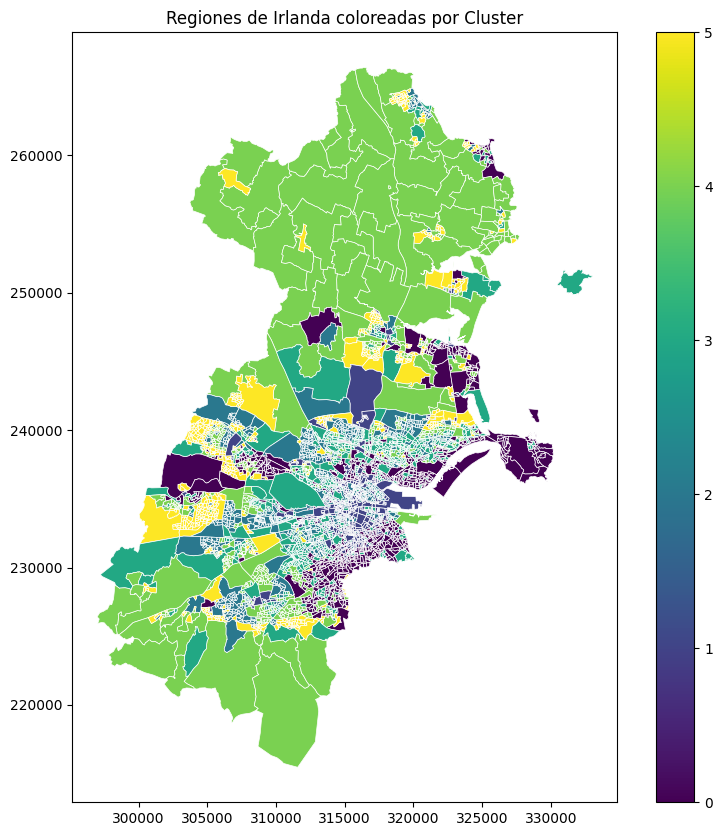

In [106]:
# Cargar el mapa (shapefile)
ireland_map = gpd.read_file('/content/Kohonen-Self-organising-maps-in-R/boundary_files/Census2011_Small_Areas_generalised20m.shp', encoding='ISO-8859-1')

filtered_regions = ireland_map[ireland_map['SMALL_AREA'].isin(data['id'])]
# 2. Fusionar los datos de data con ireland_map_filtered utilizando SMALL_AREA como clave de fusión
merged_map = filtered_regions.merge(data[['id', 'Cluster']], left_on='SMALL_AREA', right_on='id', how='inner')
# 3. Visualizar el mapa coloreado por el valor de Cluster utilizando la escala de color viridis
fig, ax = plt.subplots(figsize=(10, 10))
merged_map.plot(column='Cluster', cmap='viridis', linewidth=0.5, ax=ax, edgecolor='white', legend=True)
ax.set_title('Regiones de Irlanda coloreadas por Cluster')
plt.show()

Se pueden observar, por ejemplo, grandes regiones de cluster 4 al norte y al sur, ésto es edades de 35.3 años en media, nivel de educación medio, 1.5 coches por unidad familiar y alrededor de un 10.8% de desempleo. También se observa que las zonas con menor desempleo y mayor grado de educación medio están concentradas, probablemente en torno a los centros de empleo más cualificado. Los patrones discrepantes pueden ayudar a expertos en territorio a detectar situaciones que, en volúmenes grandes de datos podrían pasar desapercibidos.